## Testing model at varying levels of dropout

I want to load my model and test how it performs on validation data and train data on varying levels of dropout.

In [37]:
import sys
sys.path.append('/home/jxm3/research/deidentification/unsupervised-deidentification')

from dataloader import WikipediaDataModule

import os

num_cpus = os.cpu_count()
dm = WikipediaDataModule(
    document_model_name_or_path="roberta-base",
    profile_model_name_or_path="google/tapas-base",
    max_seq_length=128,
    dataset_name='wiki_bio',
    dataset_train_split='train[:1]', # not used
    dataset_val_split='val[:20%]',
    dataset_version='1.2.0',
    word_dropout_ratio=0.0,
    word_dropout_perc=0.0,
    num_workers=1,
    train_batch_size=64,
    eval_batch_size=64
)
dm.setup("fit")

Initializing WikipediaDataModule with num_workers = 1 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:1]


Using custom data configuration default
Reusing dataset wiki_bio (/home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da)


loading wiki_bio[1.2.0] split val[:20%]


Using custom data configuration default
Reusing dataset wiki_bio (/home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da)
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-b98e3ae8bfedd5c6.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-7d07543b6205ca87.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-7440752484ad8676.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-2c6f94b0d2dcc153.arrow


In [38]:
from model import CoordinateAscentModel

# model that was trained at the link given above, gets >99% validation accuracy,
# and is trained with word dropout!

from model_cfg import model_paths_dict

checkpoint_path = model_paths_dict["model_5"]

model = CoordinateAscentModel.load_from_checkpoint(
    checkpoint_path,
    document_model_name_or_path="roberta-base",
    profile_model_name_or_path="google/tapas-base",
    learning_rate=1e-5,
    pretrained_profile_encoder=False,
    lr_scheduler_factor=0.5,
    lr_scheduler_patience=1,
    train_batch_size=1,
    num_workers=1,
    gradient_clip_val=10.0,
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initialized model with learning_rate = 1e-05 and patience 1


In [39]:
import numpy as np
import torch
import tqdm

def precompute_profile_embeddings():
    model.profile_model.cuda()
    model.profile_model.eval()

    model.val_profile_embeddings = np.zeros((len(dm.val_dataset), model.profile_embedding_dim))
    for val_batch in tqdm.tqdm(dm.val_dataloader()[0], desc="Precomputing val embeddings", colour="green", leave=False):
        with torch.no_grad():
            profile_embeddings = model.forward_profile(batch=val_batch)
        model.val_profile_embeddings[val_batch["text_key_id"]] = profile_embeddings.cpu()
    model.val_profile_embeddings = torch.tensor(model.val_profile_embeddings, dtype=torch.float32)
    model.profile_model.train()

precompute_profile_embeddings()

In [41]:
model.profile_model.cuda()
model.document_model.cuda()
model.document_embed.cuda()
model.val_profile_embeddings = model.val_profile_embeddings.cuda()

In [69]:
from torch.utils.data import DataLoader
from masking_tokenizing_dataset import MaskingTokenizingDataset

val_tokenizing_dataset = MaskingTokenizingDataset(
    dm.val_dataset,
    document_tokenizer=dm.document_tokenizer,
    profile_tokenizer=dm.profile_tokenizer,
    max_seq_length=dm.max_seq_length,
    word_dropout_ratio=0.0,
    word_dropout_perc=0.0,
    profile_row_dropout_perc=0.0,
    sample_spans=False,
    document_types=["document"],
    is_train_dataset=True
)

import tqdm

accs = {}

for dropout_amount in np.arange(0.0, 1.0+.1, 0.1): # [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    num_correct = 0
    num_total = 0
    print(f'Testing with dropout at {dropout_amount*100}%')
    val_tokenizing_dataset.masking_span_sampler.word_dropout_perc = dropout_amount
    val_tokenizing_dataset.masking_span_sampler.word_dropout_ratio = 1.0
    dropout_dataloader = DataLoader(
        [val_tokenizing_dataset[i] for i in range(1000)],
        batch_size=128,
        num_workers=min(dm.num_workers, 8),
        shuffle=False
    )
    for batch in tqdm.tqdm(dropout_dataloader, leave=False):
        with torch.no_grad():
            val_emb = model.forward_document(batch=batch, document_type='document')
        pred_idxs = (val_emb @ model.val_profile_embeddings.T).argmax(dim=1)
        true_idxs = batch['text_key_id'].cuda()
        num_correct += (pred_idxs == true_idxs).sum().item()
        num_total += len(true_idxs)

    acc = num_correct / num_total
    print(acc)
    accs[dropout_amount] = acc

Testing with dropout at 0.0%


0.998
Testing with dropout at 10.0%


0.998
Testing with dropout at 20.0%


0.993
Testing with dropout at 30.000000000000004%


0.989
Testing with dropout at 40.0%


0.981
Testing with dropout at 50.0%


0.948
Testing with dropout at 60.00000000000001%


0.932
Testing with dropout at 70.0%


0.838
Testing with dropout at 80.0%


0.711
Testing with dropout at 90.0%


0.558
Testing with dropout at 100.0%


0.23


In [70]:
import pandas as pd
df = pd.DataFrame.from_dict(accs, orient='index', columns=['accuracy'])
df.head()

,accuracy
0.0,0.998
0.1,0.998
0.2,0.993
0.3,0.989
0.4,0.981


<AxesSubplot:>

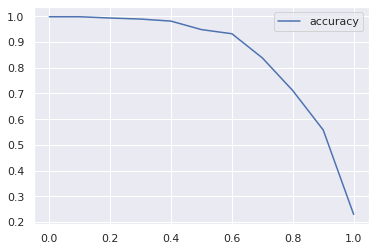

In [71]:
import seaborn as sns
sns.set()

sns.lineplot(data=df)

### What does 100% masking even look like?!

In [68]:
import random

print(val_tokenizing_dataset.masking_span_sampler.word_dropout_perc)

random_el = random.choice(dm.val_dataset)
random_document = random_el['document']
random_idx = random_el['text_key_id']

val_tokenizing_dataset.masking_span_sampler.random_redact_str(
    text=random_document
)

1.0


'<mask> <mask> is a <mask> <mask> <mask> <mask> <mask> , who was a <mask> of <mask> <mask> from <mask> to <mask> .\nshe was a <mask> <mask> on <mask> <mask>-<mask> <mask> <mask> for the <mask> <mask> from <mask> to <mask> .\nshe was an <mask> <mask> at the <mask> , <mask> and <mask> <mask> <mask> for the <mask> <mask> <mask> and was <mask> <mask> at the <mask> <mask> for the <mask> <mask> in <mask> .\nshe was <mask> by the <mask> , <mask> <mask> to <mask> <mask> on <mask> <mask> <mask> .\n<mask> was the <mask> <mask> <mask> <mask> for <mask> , <mask> <mask> , <mask> and <mask> .\nshe was a <mask> of the <mask> of the <mask> <mask> <mask> for <mask> , <mask> <mask> for the <mask> <mask> for the <mask> of the <mask> .\nshe is a <mask> of the <mask> <mask> of <mask> , <mask> <mask> <mask> , the <mask> <mask> <mask> for <mask> (<mask>) and the <mask> <mask> and <mask> <mask> .\n'

### OK no way model can get this right right?? How is that 23%? Something must be wrong??!

In [73]:
num_correct = 0
num_total = 0
print(f'Testing with dropout at {dropout_amount*100}%')
val_tokenizing_dataset.masking_span_sampler.word_dropout_perc = 1.0
val_tokenizing_dataset.masking_span_sampler.word_dropout_ratio = 1.0
dropout_dataloader = DataLoader(
    [val_tokenizing_dataset[i] for i in range(128)],
    batch_size=128,
    num_workers=min(dm.num_workers, 8),
    shuffle=False
)
for batch in tqdm.tqdm(dropout_dataloader, leave=False):
    with torch.no_grad():
        val_emb = model.forward_document(batch=batch, document_type='document')
    pred_idxs = (val_emb @ model.val_profile_embeddings.T).argmax(dim=1)
    true_idxs = batch['text_key_id'].cuda()
    num_correct += (pred_idxs == true_idxs).sum().item()
    num_total += len(true_idxs)

acc = num_correct / num_total

Testing with dropout at 100.0%


In [74]:
acc

0.25

In [78]:
batch['text_key_id'][true_idxs == pred_idxs]

tensor([  6,   9,  17,  21,  24,  26,  31,  33,  38,  39,  48,  52,  54,  55,
         59,  61,  66,  69,  71,  75,  84,  91,  93,  98,  99, 102, 114, 115,
        116, 118, 119, 127])

In [84]:
i = 6
doc = val_tokenizing_dataset.dataset[i]['document']
redacted_doc = val_tokenizing_dataset.masking_span_sampler.random_redact_str(text=doc)

In [85]:
redacted_doc

"<mask> <mask> <mask> (<mask> <mask> <mask> , <mask>) , <mask> `` the <mask> <mask> '' , is an <mask> <mask> <mask> <mask> <mask> with the <mask> <mask> <mask> of <mask> <mask> <mask> (<mask>) .\nhe <mask> and <mask> <mask>-<mask> .\n<mask> was <mask> by the <mask> <mask> <mask> <mask> in the <mask> <mask> (<mask> <mask>) of the <mask> <mask> <mask> <mask> <mask> .\nhe <mask> his <mask> <mask> <mask> in <mask> .\n<mask> has more <mask> (<mask>) than any other <mask> <mask> <mask> .\n"

In [87]:
tokenized_redacted_doc = val_tokenizing_dataset.document_tokenizer.encode_plus(
    redacted_doc,
    max_length=val_tokenizing_dataset.max_seq_length,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

In [91]:
with torch.no_grad():
    val_emb = model.forward_document_inputs(tokenized_redacted_doc)
    pred_idxs = (val_emb @ model.val_profile_embeddings.T).argmax(dim=1)

In [92]:
pred_idxs

tensor([6], device='cuda:0')

In [94]:
model.val_profile_embeddings.shape

torch.Size([14566, 768])

In [97]:
(val_emb @ model.val_profile_embeddings.T).max()

tensor(12.4562, device='cuda:0')

In [99]:
(val_emb @ model.val_profile_embeddings.T)[0, 6]

tensor(12.4562, device='cuda:0')

In [103]:
(-(val_emb @ model.val_profile_embeddings.T)).argsort()[0, :10].tolist()

[6, 2706, 8580, 11514, 6999, 13843, 14514, 4986, 2057, 13247]

In [104]:
(val_emb @ model.val_profile_embeddings.T)[0, 2706]

tensor(12.3210, device='cuda:0')

In [106]:
pd.read_csv('../adv_csvs/train/model_5/results_1_50.csv')['perturbed_text'].apply(lambda s: s.count('<mask>')).mean()

6.72

#### confirming model accuracy is 0 on adv-masked examples

In [122]:
pt = pd.read_csv('../adv_csvs/model_5/results_1_100.csv')['perturbed_text'].map(lambda s: s.replace('<SPLIT>', '\n'))

In [123]:
pt

0     pope <mask> iii <mask> alexandria (also known ...
1     <mask> <mask> is a male former <mask> tennis p...
2     <mask> <mask> (born 30 november <mask>) is a <...
3     <mask> <mask> , (born march 14 , <mask>) is a ...
4     <mask> <mask>. <mask> is a former democratic m...
                            ...                        
95    <mask> `` <mask> '' maria giuseppe carlo ignaz...
96    <mask> j. donnelly (<mask> <mask> , <mask> -- ...
97    <mask> <mask> (born <mask> 15 , <mask> in regi...
98    <mask> <mask>. <mask> (january <mask> , <mask>...
99    <mask> ` <mask> ' <mask> (born 21 <mask> <mask...
Name: perturbed_text, Length: 100, dtype: object

In [111]:
def get_model_predicted_idx(s: str) -> int:
    tokenized_doc = val_tokenizing_dataset.document_tokenizer.encode_plus(
        s,
        max_length=val_tokenizing_dataset.max_seq_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
    )
    with torch.no_grad():
        val_emb = model.forward_document_inputs(tokenized_doc)
        pred_idxs = (val_emb @ model.val_profile_embeddings.T).argmax(dim=1)
    return pred_idxs.item()

In [115]:
get_model_predicted_idx(val_tokenizing_dataset.dataset[300]['document'])

300

In [124]:
pt_idxs = pt.map(get_model_predicted_idx)
pt_idxs

0      6582
1     10388
2      8151
3      4726
4      3564
      ...  
95       95
96       96
97       97
98     9510
99       99
Name: perturbed_text, Length: 100, dtype: int64

In [125]:
(pt_idxs == pt_idxs.index).sum()

56

In [126]:
pt[0]

'pope <mask> iii <mask> alexandria (also known as khail iii) was <mask> <mask> pope of <mask> <mask> patriarch of <mask> see of st. mark (880 -- <mask>) .\nin 882 , the governor of egypt , ahmad ibn tulun , forced khail to pay heavy contributions , forcing him to sell a church and some attached properties to the local jewish community .\nthis building was at one time believed to have later become the site of the cairo geniza .\n'

In [130]:
val_tokenizing_dataset.dataset[6582]['name']

'Halil Hayreddin'

In [131]:
val_tokenizing_dataset.dataset[0]['document']

'pope michael iii of alexandria (also known as khail iii) was the coptic pope of alexandria and patriarch of the see of st. mark (880 -- 907) .\nin 882 , the governor of egypt , ahmad ibn tulun , forced khail to pay heavy contributions , forcing him to sell a church and some attached properties to the local jewish community .\nthis building was at one time believed to have later become the site of the cairo geniza .\n'

In [132]:
get_model_predicted_idx('pope <mask> iii <mask> alexandria (also known as khail iii) was <mask> <mask> pope of <mask> <mask> patriarch of <mask> see of st. mark (880 -- <mask>) .\nin 882 , the governor of egypt , ahmad ibn tulun , forced khail to pay heavy contributions , forcing him to sell a church and some attached properties to the local jewish community .\nthis building was at one time believed to have later become the site of the cairo geniza .\n')

6582

In [133]:
get_model_predicted_idx('pope michael iii of alexandria (also known as khail iii) was the coptic pope of alexandria and patriarch of the see of st. mark (880 -- 907) .\nin 882 , the governor of egypt , ahmad ibn tulun , forced khail to pay heavy contributions , forcing him to sell a church and some attached properties to the local jewish community .\nthis building was at one time believed to have later become the site of the cairo geniza .\n')

0

In [138]:
get_model_predicted_idx('pope <mask> <mask> of alexandria')

12746

In [139]:
val_tokenizing_dataset.dataset[12746]['name']

'Boniface V'